This notebook is adapted from the inpainting.ipynb notebook from Ulyanov et al.'s [Deep Image Prior paper](https://sites.skoltech.ru/app/data/uploads/sites/25/2018/04/deep_image_prior.pdf) + [Github repository](https://github.com/DmitryUlyanov/deep-image-prior) as well as Liu et al.'s [Partial Convolutions for Inpainting paper](https://arxiv.org/abs/1804.07723) + [Github repository](https://github.com/MathiasGruber/PConv-Keras). It also uses color restoration developed by Geoff Daniell in [this repository.](https://github.com/stongey/PhotoRestore)

In [4]:
# If you are not running this in Colab, comment out this cell.

from google.colab import drive     

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd drive/My\ Drive/deep-image-prior

/content/drive/My Drive/deep-image-prior


# Inpainting and Color Restoration on a single image 

In this section, we are performing exclusively the Deep Image Prior method of inpainting, as well as the color restoration by Daniell. All of the inpainting algorithms are implemented further below.

First we are importing some libraries and setting some variables. 'painting' refers to the name of the painting to restore. Name your damaged painting image as "{painting}_orig_crop.jpg", mask as "{painting}_mask.jpg", and ground truth (if available) as "{painting}_gt.jpg", or modify the code as needed. The binary mask should be black where you want to inpaint, and white everywhere else. 

In [6]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cv2
import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
painting = "unknown"
dim_div_by = 64

In [7]:
img_path = f'data/inpainting/{painting}_orig_crop.jpg'
mask_path = f'data/inpainting/{painting}_mask.jpg'
ground_truth_path = f'data/inpainting/{painting}_gt.jpg'

ground_truth = Image.open(ground_truth_path)
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

In [8]:
img_orig = cv2.imread(img_path)
imsize = (img_orig.shape[1], img_orig.shape[0])

In [9]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

In [10]:
# Center crop of image and mask
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

Here we can visualize the cropped iamge and mask overlay. Uncomment the cell below to visualize.

In [11]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

# plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

Now we are setting up the network. Feel free to change things as needed.

In [ ]:
pad = 'zero' # or 'reflection' 
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [ ]:
if painting in img_path:
    
    INPUT = 'noise' # or 'meshgrid'
    input_depth = 1    #can make 2 or 32?
    
    num_iter = 5000
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [ ]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 2996467


This is the main loop. 'indices' is the crop for each ground truth image to match up to the output from the network, but there's probably a better way to do this (i.e. using their crop image function). 

In [ ]:
i = 0
mses = []
indices = {'stork':(5,901,26,1754), 'ecce_homo':(3,451,11,331), 'unknown':(9,393,2,322), 'unknown2':(6,198,18,146), 'davinci':(11,587,15,399), 'unknown3':(12,588,21,469), 'monet':(2,322,4,388)}
x1, x2, y1, y2 = indices[painting]
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        mses.append(mean_sq_error(Image.fromarray(np.array(ground_truth)[x1:x2,y1:y2]),Image.fromarray((out_np.transpose(1,2,0) * 255).astype(np.uint8))))
        print(mean_sq_error(Image.fromarray(np.array(ground_truth)[x1:x2,y1:y2,:]),Image.fromarray((out_np.transpose(1,2,0) * 255).astype(np.uint8)))) # unknown3

        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Below is the MSE computed every 50 iterations until iteration 5000 (or your stopping point).

In [ ]:
plt.plot([50 * i for i in range(100)], mses)
plt.title(f"MSE of {painting}")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.savefig(f"MSE_{painting}.jpg")


In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [ ]:
final_img = Image.fromarray((out_np.transpose(1,2,0) * 255).astype(np.uint8))

We are saving the output from the network below - this is not the fully restored painting yet.

In [ ]:
final_img.save(f"data/{painting}_inpainted_dip.jpg")

Next, we need to put the generated output onto the original damaged painting in regions we specified with the mask.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import cv2

Sorry for the undescriptive names, but 'before' is the original damaged painting, and mask is the binary mask read in greyscale.

In [ ]:
before = cv2.imread(img_path)
before = cv2.cvtColor(before, cv2.COLOR_RGB2BGR)
mask = cv2.imread(mask_path,0)

We are adding padding... there's also probably a better way to do this like using 'np.pad' but this works well enough.

In [ ]:
reshaped_img = np.zeros(before.shape)
final_out = np.array(final_img)

In [ ]:
diff_shape_0 = before.shape[0] - final_out.shape[0]
diff_shape_1 = before.shape[1] - final_out.shape[1]

reshaped_img[diff_shape_0 // 2:final_out.shape[0] + diff_shape_0//2, diff_shape_1 // 2:final_out.shape[1] + diff_shape_1//2,:] = final_img

Visualization of the padded generated output.

In [ ]:
Image.fromarray(reshaped_img.astype(np.uint8))

Below is where we are appending the generated output to the original damaged input based on regions specified by the mask.

In [ ]:
locs = np.where(mask<100)
edit_before = before.copy()
edit_before[locs] = reshaped_img[locs]


In [ ]:
Image.fromarray(edit_before)

In [ ]:
Image.fromarray(edit_before).save(f"data/{painting}_final.jpg")

The MSE of the inpainted painting and the ground truth.

In [ ]:
mean_sq_error(edit_before, ground_truth)

## Color Restoration

In [ ]:
from pyrestore_3 import restore

In [ ]:
final_restored = Image.fromarray(edit_before.copy())

/content/drive/My Drive/deep-image-prior/pyrestore_3.py:504: RuntimeWarning: invalid value encountered in double_scalars
  sum_sat += sqrt(ustar**2 + vstar**2) / Lstar


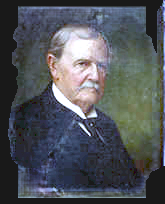

In [ ]:
col_img = restore(final_restored, f'{painting}.jpg')
col_img

# Inpainting Evaluation

In this section we are evaluating the different inpainting algorithms. The five are in functions at the very bottom, it can also probably be organized/modularized better. If you are running the PConvUnet, you should install the requirements below which may require that you restart your runtime. 

In [ ]:
pip install -r requirements.txt

In [ ]:
import numpy as np
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator, ImageChunker
import tensorflow as tf


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [ ]:
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

pad = 'zero' # or 'reflection' 
OPT_OVER = 'net'
OPTIMIZER = 'adam'

INPUT = 'noise' # or 'meshgrid'
input_depth = 1    #can make 2 or 32?

num_iter = 5000
show_every = 1000
figsize = 8
reg_noise_std = 0.00
param_noise = True

depth = int(NET_TYPE[-1])

i = 0

In [ ]:
painting_names = ['stork','ecce_homo', 'unknown', 'unknown2', 'unknown3', 'monet', 'davinci']

inpainting_algs = ['dip', 'pconv', 'hw', 'ns', 'telea']
# mses_dip, mses_pconv, mses_hw, mses_ns, mses_telea = [], [], [], [], []
# mses_pconv = []
mses_dip = []
for painting in painting_names:
    print("NEW PAINTING:",painting)
    img_path = f'data/inpainting/{painting}_orig_crop.jpg'
    mask_path = f'data/inpainting/{painting}_mask.jpg'
    ground_truth_path = f'data/inpainting/{painting}_gt.jpg'

    ground_truth_img = Image.open(ground_truth_path)
    orig_img = Image.open(img_path)
    mask_img = Image.open(mask_path)

    x, y, _ = np.array(orig_img).shape
    imsize = (y, x)


    for alg in inpainting_algs:
        print(alg)
        if alg == 'dip':
            mses_dip.append(dip(painting))

        # if alg == 'hw':
            # mses_hw.append(hw(painting))
        
        # if alg == 'ns':
            # mses_ns.append(ns(painting))
        
        # if alg == 'telea':
            # mses_telea.append(telea(painting))
        
        # if alg == 'pconv':
            # mses_pconv.append(pconv(painting))
        print("MSE DIP AFTER ",alg,":",mses_dip)
        
          
        

In [ ]:
def dip(painting):
    img_pil, img_np = get_image(img_path, imsize)
    img_mask_pil, img_mask_np = get_image(mask_path, imsize)
    
    
    img_mask_pil = crop_image(img_mask_pil, dim_div_by)
    img_pil      = crop_image(img_pil,      dim_div_by)
    
    img_np      = pil_to_np(img_pil)
    img_mask_np = pil_to_np(img_mask_pil)
    
    img_mask_var = np_to_torch(img_mask_np).type(dtype)
    print("Plotted Image:")
    plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11)
    net = skip(input_depth, img_np.shape[0], 
          num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
          num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
          num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
          filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
          upsample_mode='nearest', # downsample_mode='avg',
          need1x1_up=False,
          need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
    LR = 0.01
    
    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
    # Compute number of parameters
    s  = sum(np.prod(list(p.size())) for p in net.parameters())
    print ('Number of params: %d' % s)
    
    # Loss
    mse = torch.nn.MSELoss().type(dtype)
    
    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)
  
    
    mses = []
    indices = {'stork':(5,901,26,1754), 'ecce_homo':(3,451,11,331), 'unknown':(13,397,11,331), 'unknown2':(6,198,18,146), 'davinci':(11,587,15,399), 'unknown3':(12,588,21,469), 'monet':(2,322,4,388)}
    x1, x2, y1, y2 = indices[painting]
    def closure():
        
        global i
        
        if param_noise:
            for n in [x for x in net.parameters() if len(x.size()) == 4]:
                n = n + n.detach().clone().normal_() * n.std() / 50
        
        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
            
            
        out = net(net_input)
      
        total_loss = mse(out * mask_var, img_var * mask_var)
        total_loss.backward()
            
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        if  PLOT and i % show_every == 0:
            out_np = torch_to_np(out)
            # print(out_np.shape)
            # mses.append(mean_sq_error(Image.fromarray(np.array(ground_truth_img)[x1:x2,y1:y2]),Image.fromarray((out_np.transpose(1,2,0) * 255).astype(np.uint8))))
            # print(mean_sq_error(Image.fromarray(np.array(ground_truth_img)[x1:x2,y1:y2,:]),Image.fromarray((out_np.transpose(1,2,0) * 255).astype(np.uint8)))) # unknown3
    
    
            plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
            
        i += 1
    
        return total_loss
    
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    
    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)
    
    # plt.plot([50 * i for i in range(100)], mses)
    # plt.title(f"MSE of {painting}")
    # plt.xlabel("Iteration")
    # plt.ylabel("MSE")
    # plt.savefig(f"MSE_{painting}.jpg")
    
    
    out_np = torch_to_np(net(net_input))
    final_img = Image.fromarray((out_np.transpose(1,2,0) * 255).astype(np.uint8))
    before = cv2.imread(img_path)
    before = cv2.cvtColor(before, cv2.COLOR_RGB2BGR)
    mask = cv2.imread(mask_path,0)
    
    reshaped_img = np.zeros(before.shape)
    final_out = np.array(final_img)
    diff_shape_0 = before.shape[0] - final_out.shape[0]
    diff_shape_1 = before.shape[1] - final_out.shape[1]
    reshaped_img[diff_shape_0 // 2:final_out.shape[0] + diff_shape_0//2, diff_shape_1 // 2:final_out.shape[1] + diff_shape_1//2,:] = final_img
    locs = np.where(mask<100)
    edit_before = before.copy()
    edit_before[locs] = reshaped_img[locs]
    Image.fromarray(edit_before).save(f"data/final/{painting}_{alg}.jpg")
    print(np.array(edit_before).shape)
    print(np.array(ground_truth_img).shape)
    return mean_sq_error(edit_before, ground_truth_img)

In [ ]:
def is_border(img, i, j, pxl_color, H, W):
    count = 0
    for x in range(-1, 2):
        for y in range(-1, 2):
#             print(x,y)
            if j + y < W and x + i < H:
                if tuple(img[i + x, j + y,:]) != pxl_color:
                    count += 1
    if count > 3:
        return True
    return False

def get_border(img, mask, pxl_color, change_to, H, W):
    for i in range(H):
        for j in range(W):
    #         print(tuple(img_temp2[i,j,:]))
            if tuple(img[i,j,:]) == pxl_color:
                if is_border(img, i, j, pxl_color, H, W):
                    img[i,j,:] = change_to

def most_common(img, mask, i, j, H, W):
    count = {}
    colors = []
    for x in range(-1, 2):
        for y in range(-1, 2):
            if j + y < W and x + i < H:
                if tuple(img[i + x, j + y,:]) != (145, 44, 238) and tuple(img[i + x, j + y, :]) != (255, 255, 255):
                    colors.append(tuple(img[i+x,j+y,:]))
                    if tuple(img[i+x,j+y,:]) not in count:
                        count[tuple(img[i+x,j+y,:])] = 1
                    else:
                        count[tuple(img[i+x,j+y,:])] += 1

        
    x = max(count)
    y = max(set(colors), key=colors.count)

    return(y)


def hw(painting):
    before = cv2.imread(img_path)
    before = cv2.cvtColor(before, cv2.COLOR_RGB2BGR)
    H, W, _ = before.shape
    mask = cv2.imread(mask_path,0)

    locs = np.where(mask < 2)
    locs2 = np.where(mask > 250)
    mask[locs] = 0 
    mask[locs2] = 255 

    print(np.unique(mask))
    img_orig = before.copy()
    plt.imshow(img_orig)
    locs = np.where(mask < 100)
    img_temp2 = before.copy()
    img_temp2[locs[0],locs[1],:] = [145, 44, 238]
    img_temp3 = img_temp2.copy()

    def change_border(img):
        for i in range(H):
            for j in range(W):
                if tuple(img_temp2[i,j,:]) == (255, 255, 255):
                    col = most_common(img, mask, i, j, H, W)
                    img[i,j,:] = col
                    img_orig[i,j,:] = col
    for i in range(10):
        get_border(img_temp2, mask, (145, 44, 238), [255, 255, 255], H, W)
        change_border(img_temp3)
        img_temp2 = img_temp3.copy()

    plt.imshow(img_temp2)
    Image.fromarray(img_temp2).save(f"data/final/{painting}_{alg}.jpg")

    return mean_sq_error(img_temp2, ground_truth_img)

In [ ]:
def ns(painting):
    
    before = cv2.imread(img_path)
    before = cv2.cvtColor(before, cv2.COLOR_RGB2BGR)
    plt.imshow(before)
    mask = cv2.imread(mask_path,0)
    mask = cv2.imread(mask_path,0)
    locs = np.where(mask < 2)
    locs2 = np.where(mask > 250)
    mask[locs] = 255
    mask[locs2] = 0
    after_ns = cv2.inpaint(before,mask,3,cv2.INPAINT_NS)
    Image.fromarray(after_ns).save(f"data/final/{painting}_{alg}.jpg")
    plt.imshow(after_ns)
    return mean_sq_error(after_ns, ground_truth_img)

In [ ]:
def telea(painting):
    before = cv2.imread(img_path)
    before = cv2.cvtColor(before, cv2.COLOR_RGB2BGR)
    # plt.imshow(before)
    mask = cv2.imread(mask_path,0)
    locs = np.where(mask < 2)
    locs2 = np.where(mask > 250)
    mask[locs] = 255
    mask[locs2] = 0
    print(np.unique(mask)) 
    after_telea = cv2.inpaint(before,mask,3,cv2.INPAINT_TELEA)
    plt.imshow(after_telea)
    Image.fromarray(after_telea).save(f"data/final/{painting}_{alg}.jpg")
    return mean_sq_error(after_telea, ground_truth_img)

In [ ]:
def pconv(painting):
    BATCH_SIZE = 4
    sample = Image.open(img_path)
    H, W, _ = np.array(sample).shape
    crop = [H, W]
    img = np.array(sample) / 255
    mask = MaskGenerator(*crop, filepath=f'data/inpainting/{painting}')._load_mask(False, False, False)

    model = PConvUnet(inference_only=True)#vgg_weights=None, inference_only=True)
    model.load(r"data/pconv_imagenet.03-11.07.h5", train_bn=False)
    chunker = ImageChunker(512, 512, 30)

    chunked_images = chunker.dimension_preprocess(deepcopy(img))
    chunked_masks = chunker.dimension_preprocess(deepcopy(mask))
    pred_imgs = model.predict([chunked_images, chunked_masks])
    reconstructed_image = chunker.dimension_postprocess(pred_imgs, img)
    output = Image.fromarray((reconstructed_image * 255).astype(np.uint8))
    output.save(f"data/final/{painting}_{alg}.jpg")
    return mean_sq_error(output, ground_truth_img)


In [ ]:
with open("data/mses.txt", 'a') as f:
    # f.write(f"mses_hw,{np.mean(mses_hw)},{mses_hw}\n")
    # f.write(f"mses_ns,{np.mean(mses_ns)},{mses_ns}\n")
    # f.write(f"mses_telea,{np.mean(mses_telea)},{mses_telea}\n")
    # f.write(f"mses_pconv,{np.mean(mses_pconv)},{mses_pconv}\n")
    f.write(f"mses_dip,{np.mean(mses_dip)},{mses_dip}\n")
